In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import os
import random

# --- NEW: FIXING RANDOMNESS (REPRODUCIBILITY) ---
# We choose a "seed" (a magic number), 42 is a convention
SEED = 42

# 1. Set the seed for native Python
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

# 2. Set the seed for NumPy
np.random.seed(SEED)

# 3. Set the seed for TensorFlow
tf.random.set_seed(SEED)

# (Optional: can slow down training, but ensures full determinism)
# tf.config.experimental.enable_op_determinism()

print(f"--- Randomness fixed with seed: {SEED} ---")

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Keras Imports (including Callbacks)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Add src to path
sys.path.append('../src')
from src.preprocess import normalize_flux

print(f"TensorFlow Version: {tf.__version__}")

--- Randomness fixed with seed: 42 ---
TensorFlow Version: 2.20.0


In [2]:
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Map labels {1: 0, 2: 1}
df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

# Separate X/y
X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

# Fill NaNs
X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

print("Normalizing data (detrending)...")
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1).values
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1).values

print("Reshaping data for CNN...")
X_train_cnn = X_train_normalized[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}
print("--- Data preparation complete ---")

Loading data...
Normalizing data (detrending)...
Reshaping data for CNN...
--- Data preparation complete ---


In [3]:
print("Building v5 model architecture...")
INPUT_SHAPE = (X_train_cnn.shape[1], 1)

model_v5 = Sequential([
    Input(shape=INPUT_SHAPE),
    # Block 1
    Conv1D(filters=8, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    # Block 2
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    # Block 3
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    # Head
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.6), # The seed will also make this dropout reproducible
    Dense(1, activation='sigmoid')
])

model_v5.summary()

Building v5 model architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

In [5]:
# hypothesis test: v2's high LR + v3's Callbacks

MODEL_SAVE_PATH = '../models/cnn_model_v5.keras'

# 1. ModelCheckpoint
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_pr_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 2. EarlyStopping
early_stopping_cb = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

CALLBACK_LIST = [checkpoint_cb, early_stopping_cb]

# 3. Compile with the HIGH learning rate (from v2)
print("Compiling v5 model with 'v2' learning rate (0.001)...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')

model_v5.compile(
    optimizer=Adam(learning_rate=0.001), # Testing the v2 (unstable) LR
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)

print("Model compiled.")

Compiling v5 model with 'v2' learning rate (0.001)...
Model compiled.


In [6]:
# --- 4. Train the Model (v5) ---
print("Starting v5 (reproducible) training...")

history_v5 = model_v5.fit(
    X_train_cnn,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weight_dict,
    callbacks=CALLBACK_LIST
)

print("Training finished.")

Starting v5 (reproducible) training...
Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4979 - loss: 2.4729 - pr_auc: 0.0073
Epoch 1: val_pr_auc improved from None to 0.00694, saving model to ../models/cnn_model_v5.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 2.2656 - pr_auc: 0.0074 - val_accuracy: 0.1140 - val_loss: 0.7895 - val_pr_auc: 0.0069
Epoch 2/50
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6825 - loss: 1.1469 - pr_auc: 0.0262
Epoch 2: val_pr_auc improved from 0.00694 to 0.00831, saving model to ../models/cnn_model_v5.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6914 - loss: 1.1125 - pr_auc: 0.0298 - val_accuracy: 0.9877 - val_loss: 0.2255 - val_pr_auc: 0.0083
Epoch 3/50
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7042 - loss: 0.6856 - pr_auc: 0.0642
Epoch 3: val_pr_auc improved from 0.00831 to 0.01232, saving model to ../models/cnn_model_v5.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step -

In [7]:
print("Evaluating v5 model (with best weights)...")

y_pred_proba_cnn_v5 = model_v5.predict(X_test_cnn).flatten()
y_pred_cnn_v5 = (y_pred_proba_cnn_v5 > 0.5).astype(int)

print("\nConfusion Matrix (CNN v5):")
cm_cnn_v5 = confusion_matrix(y_test, y_pred_cnn_v5)
print(cm_cnn_v5)

print("\nClassification Report (CNN v5):")
print(classification_report(y_test, y_pred_cnn_v5, target_names=['No Planet (0)', 'Planet (1)']))

Evaluating v5 model (with best weights)...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Confusion Matrix (CNN v5):
[[565   0]
 [  5   0]]

Classification Report (CNN v5):
               precision    recall  f1-score   support

No Planet (0)       0.99      1.00      1.00       565
   Planet (1)       0.00      0.00      0.00         5

     accuracy                           0.99       570
    macro avg       0.50      0.50      0.50       570
 weighted avg       0.98      0.99      0.99       570



C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Plotting training history...


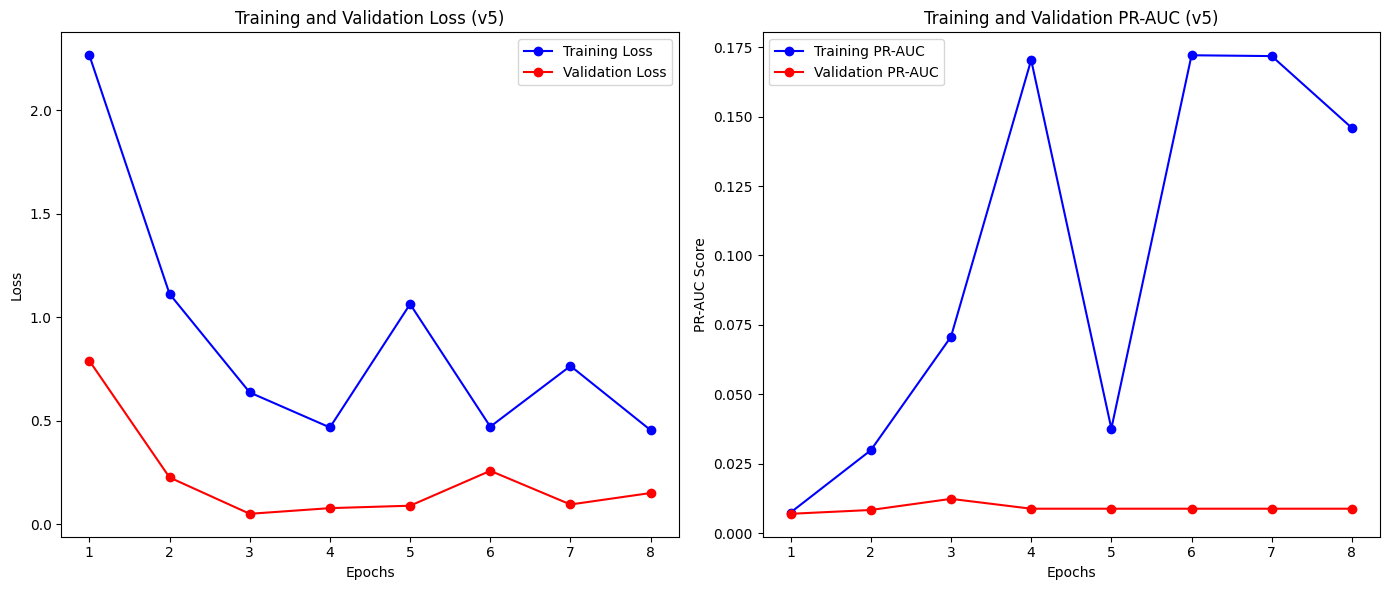

In [8]:
print("\nPlotting training history...")

history_dict = history_v5.history
loss = history_dict['loss']; val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']; val_pr_auc = history_dict['val_pr_auc']
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(14, 6))
# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (v5)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

# Plot 2: PR-AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('Training and Validation PR-AUC (v5)')
plt.xlabel('Epochs'); plt.ylabel('PR-AUC Score'); plt.legend()

plt.tight_layout()
plt.show()